In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np, pandas as pd

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else "cpu"
)

In [34]:
EPOCHS = 100
LEARNING_RATE = 0.00001
RUNS = 2
STARTING_YEAR = 2012
TRAIN_YEARS = 3
TEST_YEARS = 1
TICKER = "GOOG"

In [35]:
data = yf.download(TICKER, start="2012-01-01", end="2024-08-15", interval="1d")
selected_columns = data[['Open', 'High', 'Low', 'Close']]
print(data.head())

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-01-03  16.262545  16.641375  16.248346  16.573130  16.532528  147611217
2012-01-04  16.563665  16.693678  16.453827  16.644611  16.603836  114989399
2012-01-05  16.491436  16.537264  16.344486  16.413727  16.373516  131808205
2012-01-06  16.417213  16.438385  16.184088  16.189817  16.150156  108119746
2012-01-09  16.102144  16.114599  15.472754  15.503389  15.465409  233776981


In [36]:
in_scaler = MinMaxScaler()
out_scaler = MinMaxScaler()
close = selected_columns["Close"].to_numpy()
out_scaler.fit(np.expand_dims(close, axis=0))
scaled = in_scaler.fit_transform(selected_columns)
selected_columns = pd.DataFrame(scaled, index=selected_columns.index, columns=selected_columns.columns)
print(selected_columns.head())

                Open      High       Low     Close
Date                                              
2012-01-03  0.012972  0.014399  0.013506  0.014821
2012-01-04  0.014666  0.014691  0.014668  0.015221
2012-01-05  0.014259  0.013819  0.014050  0.013929
2012-01-06  0.013842  0.013267  0.013142  0.012677
2012-01-09  0.012070  0.011461  0.009118  0.008836


In [37]:
class StockRegressorModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(30, 64)
    self.linear2 = nn.Linear(64, 64)
    self.linear3 = nn.Linear(64, 32)
    self.linear4 = nn.Linear(32, 1)

  def forward(self, x):
      x = F.relu(self.linear1(x))
      x = F.relu(self.linear2(x))
      x = F.relu(self.linear3(x))
      x = self.linear4(x)
      return x.squeeze()  # Squeeze to remove potential singleton dimension
  

In [38]:
def walk_forward_split(start_year, train_years, test_years):

  '''
  Produces training period sequence starting at @param start_year 
  for @param train_years and test data starting at start_year + train_year
  for test_year (non overlapping ranges) respectively. 
  
  Called repeatedly to create WF train/test cycles.
  '''

  train_mask = (selected_columns.index[:] >= f'{start_year}-01-01') & (selected_columns.index[:] < f'{start_year + train_years}-01-01')
  test_mask = (selected_columns.index[:] >= f'{start_year + train_years}-01-01') & (selected_columns.index[:] < f'{start_year + train_years + test_years}-01-01')

  train_split = torch.tensor(selected_columns[train_mask].values, dtype=torch.float32).to(device)
  test_split = torch.tensor(selected_columns[test_mask].values, dtype=torch.float32).to(device)

  x_train = []
  y_train = []
  x_test = []
  y_test = []

  # Each input contains 3 features each day * 10 days
  for i in range(train_split.shape[0] - 10):
    x_train.append(train_split[i:i+10, :-1].flatten()) # flattening sequential data
    y_train.append(train_split[i+10-1, 3])

  for i in range(test_split.shape[0] - 10):
    x_test.append(test_split[i:i+10, :-1].flatten())
    y_test.append(test_split[i+10-1, 3])

  x_train = torch.stack(x_train, dim = 0).to(device)
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
  x_test = torch.stack(x_test, dim = 0).to(device)
  y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

  return x_train, y_train, x_test, y_test

In [39]:
model_0 = StockRegressorModel().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer= optimizer, step_size=1000, gamma=0.1)

In [59]:
def plot_figure(pred, actual):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label="Actual")
    plt.plot(pred, label="Predicted")
    plt.title("Price Prediction vs Actual")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

0.003330714302137494
Epoch: 0 | Train Loss: 0.010544316843152046 | Test Loss: 0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
Epoch: 10 | Train Loss: 0.010544316843152046 | Test Loss: 0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
Epoch: 20 | Train Loss: 0.010544316843152046 | Test Loss: 0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
0.003330714302137494
Epoch: 30 | Train Loss: 0.010544316843152046 | Test Loss: 0.003330714302137494
0.003330714302137494
0.00333071430

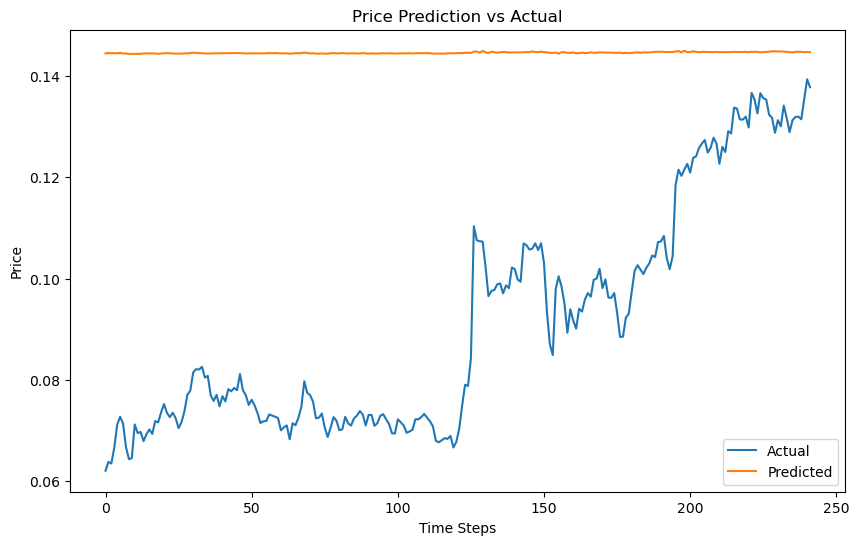

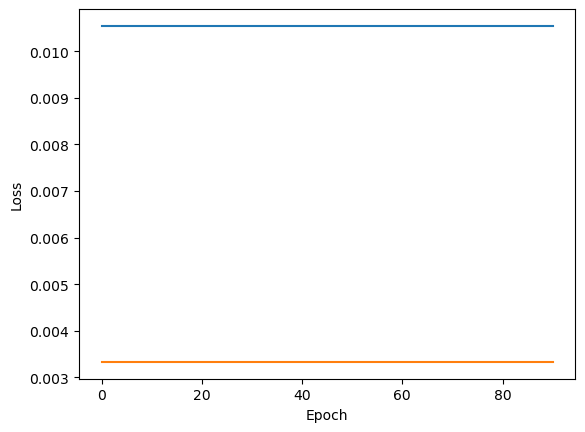

0.00030544595210812986
Epoch: 0 | Train Loss: 0.005842811893671751 | Test Loss: 0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
Epoch: 10 | Train Loss: 0.005842811893671751 | Test Loss: 0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
Epoch: 20 | Train Loss: 0.005842811893671751 | Test Loss: 0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
0.00030544595210812986
Epoch: 30 | Train Loss: 0.005842811893671751 

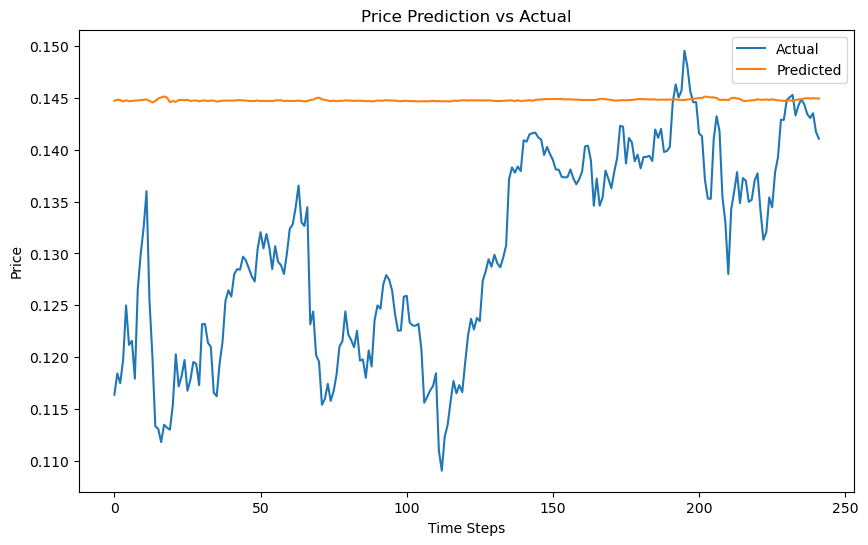

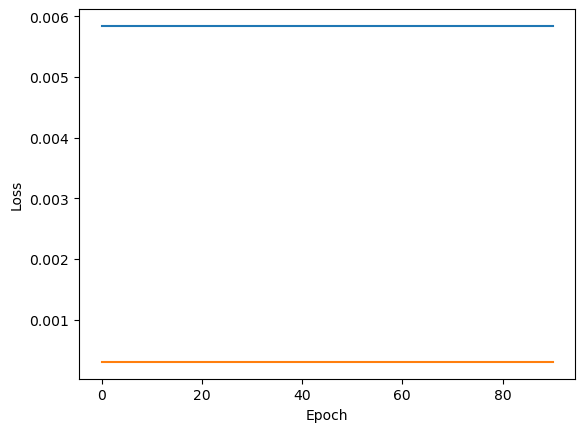

In [60]:
for run in range(RUNS):
    x_train, y_train, x_test, y_test = walk_forward_split(STARTING_YEAR + run, TRAIN_YEARS, TEST_YEARS)

    train_loss_history = []
    test_loss_history = []
    epoch_count = []

    for epoch in range(EPOCHS):
    
        # Training loop
        model_0.train()
        
        y_pred = model_0(x_train)
        
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        
        optimizer.zero_grad()
        optimizer.step()
          
        scheduler.step()
        
        # Test
        model_0.eval()
        
        with torch.inference_mode():
            test_pred = model_0(x_test)
            test_loss = loss_fn(test_pred, y_test)
            print(test_loss.item())
        
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_history.append(loss.cpu().detach().numpy())
            test_loss_history.append(test_loss.cpu().detach().numpy())
            print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")
        
    predictions = test_pred.cpu().detach().numpy().flatten()
    actual = y_test.cpu().detach().numpy().flatten()
    # print(np.expand_dims(predictions, axis=0).shape)

    # plot_figure(out_scaler.inverse_transform(predictions), out_scaler.inverse_transform(actual))
    plot_figure(predictions, actual)
    plt.plot(epoch_count, train_loss_history, label="Train loss")
    plt.plot(epoch_count, test_loss_history, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()